# Prepare dataset and splits

For zero-shot learning examples, we're going to need three datasets to be combined. 
- [TinySOL dataset](https://zenodo.org/record/3685367)
- [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/)
- [PPMI dataset](https://ai.stanford.edu/~bangpeng/ppmi.html)

In this chapter, we'll briefly go over what kind of data in provided from each dataset. Also, we're going to see how to combine two datasets and prepare their seen / unseen label splits. 

## 1. Prepare dataset

We provide pre-handled dataset from [this link](https://drive.google.com/file/d/1kvwRMWZ_RCP_H1rLtia1w6MIpLwFamEN/view?usp=sharing).

If you unzip the file, you will get the following directories and files.

```
data/
    TinySOL/                        # TinySOL dataset (metadata / audio files)
        TinySOL_metadata.csv
        audio/
            Brass/
                Bass_Tuba/
                    ordinario/
                        AUDIO_FILES
                Trombone/
                ..
            Keyboards/
            ..
    ppmip/                          # PPMI-playing dataset (images / folder names as labels)
        seen/
            bassoon/
                IMAGE_FILES
            flute/
            ..
        unseen/
            ..
    inst_glove_vector.p             # Dictionary of GloVe embeddings for instrument words

```

In [2]:
import os
import glob
import random
import pickle
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import Audio, display
from PIL import Image

from zsl.utils import draw_pca_with_class, draw_tsne_with_class

Now let's look into some example data.

### 1) TinySOL

In [3]:
ts_df = pd.read_csv('./data/TinySOL/TinySOL_metadata.csv')
curr_audio_path = ts_df.loc[(ts_df['Instrument (in full)'] == 'Cello')]['Path'].tolist()[10]

In [4]:
curr_audio, sr = librosa.load(os.path.join('./data/TinySOL/audio/', curr_audio_path))
Audio(data=curr_audio, rate=sr)

### 2) PPMI

In [5]:
data_dir = './data/ppmip/seen' 

# Grab all image files with their labels from the data folder. 
seen_img_path = []
seen_img_label = []
for f in glob.glob(os.path.join(data_dir, '**/*.jpg'), recursive=True):
    seen_img_path.append(os.path.relpath(f))
    seen_img_label.append(os.path.relpath(f).split('/')[-3])

bassoon (258, 258, 3)


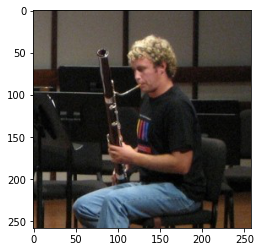

In [6]:
n = random.randint(0, len(seen_img_path)-1)
img_data = np.asarray(Image.open(seen_img_path[n]))
print(seen_img_label[n], img_data.shape)
plt.imshow(img_data)

### 3) GloVe word vectors

In [7]:
with open('./data/inst_glove_vector.p', 'rb') as f:
    inst_word_emb_dict = pickle.load(f)

In [8]:
inst_word_embeddings, inst_word_classes = [], []
for word, emb in inst_word_emb_dict.items():
    inst_word_embeddings.append(emb)
    inst_word_classes.append(word)

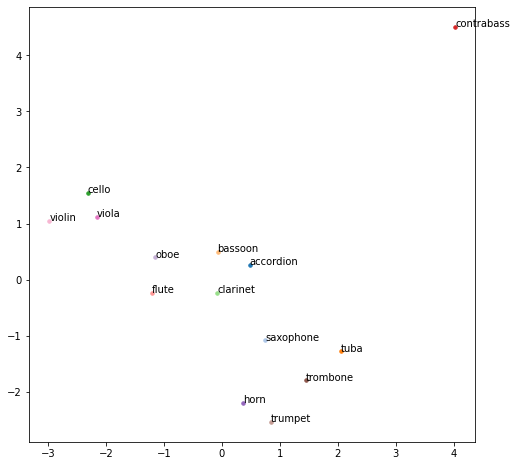

In [8]:
draw_pca_with_class(inst_word_embeddings, list(range(14)), inst_word_classes)

## 2. Construct the zero-shot data split

### 1) Merging two datasets

To construct the proper data split for zero-shot learning experiments, we first need to combine and merge two datasets. However, we face a tricky business of syncing their labels because the some labels are only present in one of the two datasets and the textual representations of the same classes are often different (e.g. 'clarinet' in word embedding dataset and 'Clarinet in Bb' in audio dataset.

For our coding session, we manually did this matching and filtering process. 
- 14 overlapping classes for TinySOL and GloVe
- 8 overlapping classes for TinySOL and PPMI

Also, to keep one-to-one mapping from one dataset to the other, we chose to have the lists in the same order so that one dataset's label indices would match with the corresponding label's in the other dataset.

### 2) Splitting labels into seen and unseen groups

Then we need to split the overlapping label set into seen and unseen groups. Because the size of our example dataset is very small, we carefully selected the labels in each group so that the characteristics of instruments in each are balanced.


#### Class split (seen / unseen) for TinySOL labels / GloVe word vector

In [ ]:
# GloVe word classes (seen / unseen)
seen_word_classes = [
    'horn', 
    'violin', 
    'flute', 
    'contrabass', 
    'trombone', 
    'cello', 
    'clarinet', 
    'oboe',
    'accordion'
]

unseen_word_classes = [
    'bassoon', 
    'viola', 
    'trumpet', 
    'tuba',
    'saxophone'
]

# TinySOL audio classes (seen / unseen)
seen_audio_classes = [
    'French Horn', 
    'Violin', 
    'Flute', 
    'Contrabass', 
    'Trombone', 
    'Cello', 
    'Clarinet in Bb', 
    'Oboe',
    'Accordion'
]

unseen_audio_classes = [
    'Bassoon', 
    'Viola', 
    'Trumpet in C', 
    'Bass Tuba', 
    'Alto Saxophone'
]

#### Class split (seen / unseen) for TinySOL labels / PPMI dataset

In [4]:
# PPMI image classes (seen / unseen)
seen_img_classes = [
    'bassoon',
    'flute',
    'trumpet',
    'violin'
]
unseen_img_classes = [
    'cello',
    'clarinet',
    'frenchhorn',
    'saxophone',
]

# TinySOL audio classes (seen / unseen)
seen_audio_classes = [
    'Bassoon',
    'Flute',
    'Trumpet in C',
    'Violin'
]
unseen_audio_classes = [
    'Cello',
    'Clarinet in Bb',
    'French Horn',
    'Alto Saxophone',
]

For PPMI dataset, seen and unseen image classes are already split into subfolders.

In [ ]:
data_dir = './data/ppmip/seen' 
seen_img_path = []
seen_img_label = []
for f in glob.glob(os.path.join(data_dir, '**/*.jpg'), recursive=True):
    seen_img_path.append(os.path.relpath(f))
    seen_img_label.append(seen_img_classes.index(os.path.relpath(f).split('/')[-3]))

data_dir = './data/ppmip/unseen'
unseen_img_path = []
unseen_img_label = []
for f in glob.glob(os.path.join(data_dir, '**/*.jpg'), recursive=True):
    unseen_img_path.append(os.path.relpath(f))
    unseen_img_label.append(unseen_img_classes.index(os.path.relpath(f).split('/')[-3]))

Given seen and unseen classes, get TinySOL dataset's audio train and test split for each.

In [ ]:
def _get_audio_seen_unseen_split(seen_audio_classes, unseen_audio_classes):
    ts_df = pd.read_csv('./data/TinySOL/TinySOL_metadata.csv')
    seen_audio_X_train, seen_audio_y_train, seen_audio_X_test, seen_audio_y_test = [], [], [], []
    for i in range(len(seen_audio_classes)):
        curr_class_text = seen_audio_classes[i]

        # We use the balanced train-test fold given by the dataset.
        curr_x_tr = ts_df.loc[(ts_df['Instrument (in full)'] == curr_class_text) & (ts_df['Fold'] < 4)]['Path'].tolist()
        curr_x_ts = ts_df.loc[(ts_df['Instrument (in full)'] == curr_class_text) & (ts_df['Fold'] == 4)]['Path'].tolist()
        curr_y_tr = [i] * len(curr_x_tr)
        curr_y_ts = [i] * len(curr_x_ts)
        seen_audio_X_train.extend(curr_x_tr)
        seen_audio_y_train.extend(curr_y_tr)
        seen_audio_X_test.extend(curr_x_ts)
        seen_audio_y_test.extend(curr_y_ts)

    # Same procedure for unseen classes.
    unseen_audio_X_train, unseen_audio_y_train, unseen_audio_X_test, unseen_audio_y_test = [], [], [], []
    for i in range(len(unseen_audio_classes)):
        curr_class_text = unseen_audio_classes[i]
        curr_x_tr = ts_df.loc[(ts_df['Instrument (in full)'] == curr_class_text) & (ts_df['Fold'] < 4)]['Path'].tolist()
        curr_x_ts = ts_df.loc[(ts_df['Instrument (in full)'] == curr_class_text) & (ts_df['Fold'] == 4)]['Path'].tolist()
        curr_y_tr = [i] * len(curr_x_tr)
        curr_y_ts = [i] * len(curr_x_ts)
        unseen_audio_X_train.extend(curr_x_tr)
        unseen_audio_y_train.extend(curr_y_tr)
        unseen_audio_X_test.extend(curr_x_ts)
        unseen_audio_y_test.extend(curr_y_ts)

    return (
        seen_audio_X_train, 
        seen_audio_y_train, 
        seen_audio_X_test, 
        seen_audio_y_test,
        unseen_audio_X_train, 
        unseen_audio_y_train, 
        unseen_audio_X_test, 
        unseen_audio_y_test,
    )


All classes are contained in 
```
zsl/
    data_prep.py
```
for a quick usage.